# M4R Modelling and Forecasting Volatility in Financial Markets using Deep Learning

# Import packages and check GPU availability

In [1]:
import numpy as np
import numpy.random as npr
from scipy.stats import norm
import tensorflow.keras as keras
import tensorflow.keras.backend as kb
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics
plt.style.use('ggplot')

In [2]:
# See the availability of GPU
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


# Import data and data manipulation

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Import data

import os

filename = 'oxfordmanrealizedvolatilityindices-2022-01-05.xlsx'
search_path = '/content/drive/My Drive/Colab Notebooks'
# Search for the file
file_path = None
for root, dirs, files in os.walk(search_path):
    if filename in files:
        file_path = os.path.join(root, filename)
        break
    df = pd.read_excel(file_path)

df = pd.read_excel(file_path)

In [5]:
# Display data
df.head()

,Unnamed: 0,Symbol,rv5,open_price,rsv,bv_ss,rk_th2,rk_parzen,close_price,nobs,close_time,rv10,bv,rv10_ss,open_to_close,rk_twoscale,open_time,medrv,rv5_ss,rsv_ss
0,2000-01-03 00:00:00+00:00,.AEX,0.000130,675.67,0.000046,0.000100,0.000102,0.000179,675.44,1795,163015,0.000178,0.000100,0.000178,-0.000340,0.000103,90101,0.000050,0.000130,0.000046
1,2000-01-04 00:00:00+00:00,.AEX,0.000201,664.20,0.000147,0.000207,0.000201,0.000423,642.25,1785,163016,0.000261,0.000207,0.000261,-0.033606,0.000199,90416,0.000075,0.000201,0.000147
2,2000-01-05 00:00:00+00:00,.AEX,0.000491,633.37,0.000328,0.000361,0.000345,0.000324,632.31,1801,163016,0.000714,0.000361,0.000714,-0.001675,0.000325,90016,0.000166,0.000491,0.000328
3,2000-01-06 00:00:00+00:00,.AEX,0.000225,632.46,0.000116,0.000258,0.000221,0.000219,624.21,1799,163002,0.000182,0.000258,0.000182,-0.013130,0.000218,90016,0.000152,0.000225,0.000116
4,2000-01-07 00:00:00+00:00,.AEX,0.000138,628.93,0.000048,0.000130,0.000123,0.000155,644.86,1798,163016,0.000157,0.000130,0.000157,0.025013,0.000126,90046,0.000039,0.000138,0.000048


In [6]:
# Store only Time, Symbol, rv5 columns
df_subset = df[["Unnamed: 0",	"Symbol",	"rv5"]]
df_subset = df_subset.set_index(["Symbol"])

In [7]:
def add_log_columns(df):
  "Takes as input a dataframe and adds columns with the log of realised \
  variance for that day, for the previous one, the previous week and previous month"

  numerical_data = df.iloc[:, 1].to_numpy()  # store rv5 values in a numpy array
  log_numerical_data = np.log(numerical_data)
  df["log_t"] = log_numerical_data

  # Compute array with the log of the previous day rv5
  log_one_day = np.concatenate((np.array([-1]), log_numerical_data))  # use -1 to have NaN in logarithm to see that have mistake
  log_one_day = log_one_day[:-1]
  df["log_prev_day"] = log_one_day

  # Compute array with avg of logs of past 5 rv5 (previous week)

  padded_arr = np.pad(log_numerical_data, (5, 0), mode='constant')

  # Use np.convolve to compute the rolling average
  kernel = np.ones(5) / 5
  rolling_avg = np.convolve(padded_arr, kernel, mode='valid')

  # Create the new array with -1 for the first four entries and rolling average for the rest
  log_one_week = -1 * np.ones_like(log_numerical_data, dtype=float)
  log_one_week[5:] = rolling_avg[5:-1]
  df["log_prev_week"] = log_one_week

  # Compute array with avg of logs of past 22 rv5 (previous month)

  padded_arr = np.pad(log_numerical_data, (22, 0), mode='constant')

  # Use np.convolve to compute the rolling average
  kernel = np.ones(22) / 22
  rolling_avg = np.convolve(padded_arr, kernel, mode='valid')

  # Create the new array with -1 for the first four entries and rolling average for the rest
  log_one_month = -1 * np.ones_like(log_numerical_data, dtype=float)
  log_one_month[22:] = rolling_avg[22:-1]
  df["log_prev_month"] = log_one_month

In [8]:
df_subset.loc[".FTSE"]

,Unnamed: 0,rv5
Symbol,,
.FTSE,2000-01-04 00:00:00+00:00,0.000233
.FTSE,2000-01-05 00:00:00+00:00,0.000192
.FTSE,2000-01-06 00:00:00+00:00,0.000123
.FTSE,2000-01-07 00:00:00+00:00,0.000114
.FTSE,2000-01-10 00:00:00+00:00,0.000123
...,...,...
.FTSE,2021-12-23 00:00:00+00:00,0.000006
.FTSE,2021-12-24 00:00:00+00:00,0.000011
.FTSE,2021-12-29 00:00:00+00:00,0.000098


In [9]:
indices = np.array(df["Symbol"].unique())
dataframes = []

# create transformed dataframes for each index by applying add_log_columns function
for ind in indices:
  ind_data = df_subset.loc[ind].copy()
  add_log_columns(ind_data)
  dataframes.append(ind_data)

# create dictionary
index_data = dict(zip(indices, dataframes))

index_data.keys()

<ipython-input-7-74d9eef76382>:6: RuntimeWarning: divide by zero encountered in log
  log_numerical_data = np.log(numerical_data)
<ipython-input-7-74d9eef76382>:6: RuntimeWarning: divide by zero encountered in log
  log_numerical_data = np.log(numerical_data)
<ipython-input-7-74d9eef76382>:6: RuntimeWarning: divide by zero encountered in log
  log_numerical_data = np.log(numerical_data)
<ipython-input-7-74d9eef76382>:6: RuntimeWarning: divide by zero encountered in log
  log_numerical_data = np.log(numerical_data)
<ipython-input-7-74d9eef76382>:6: RuntimeWarning: divide by zero encountered in log
  log_numerical_data = np.log(numerical_data)


dict_keys(['.AEX', '.AORD', '.BFX', '.BSESN', '.BVLG', '.BVSP', '.DJI', '.FCHI', '.FTMIB', '.FTSE', '.GDAXI', '.GSPTSE', '.HSI', '.IBEX', '.IXIC', '.KS11', '.KSE', '.MXX', '.N225', '.NSEI', '.OMXC20', '.OMXHPI', '.OMXSPI', '.OSEAX', '.RUT', '.SMSI', '.SPX', '.SSEC', '.SSMI', '.STI', '.STOXX50E'])

In [10]:
FTSE_data = index_data['.FTSE']
AEX_data = index_data['.AEX']
DAX_data = index_data['.GDAXI']
FTSE_data

,Unnamed: 0,rv5,log_t,log_prev_day,log_prev_week,log_prev_month
Symbol,,,,,,
.FTSE,2000-01-04 00:00:00+00:00,0.000233,-8.365364,-1.000000,-1.000000,-1.000000
.FTSE,2000-01-05 00:00:00+00:00,0.000192,-8.560469,-8.365364,-1.000000,-1.000000
.FTSE,2000-01-06 00:00:00+00:00,0.000123,-8.999895,-8.560469,-1.000000,-1.000000
.FTSE,2000-01-07 00:00:00+00:00,0.000114,-9.079011,-8.999895,-1.000000,-1.000000
.FTSE,2000-01-10 00:00:00+00:00,0.000123,-9.001064,-9.079011,-1.000000,-1.000000
...,...,...,...,...,...,...
.FTSE,2021-12-23 00:00:00+00:00,0.000006,-12.052225,-10.876758,-9.329786,-9.591285
.FTSE,2021-12-24 00:00:00+00:00,0.000011,-11.404944,-12.052225,-9.984231,-9.667199
.FTSE,2021-12-29 00:00:00+00:00,0.000098,-9.234109,-11.404944,-10.258448,-9.728310


In [11]:
print(len(FTSE_data))
print(len(AEX_data))
print(len(DAX_data))

5547
5611
5575


# Loss functions

In [12]:
def qlike(true_vol, pred_vol):
  "Returns the value of the QLIKE loss function, which is not \
  already implemented in Python unlike MSE"

  return np.log(pred_vol) + true_vol / pred_vol

qlike = np.vectorize(qlike)

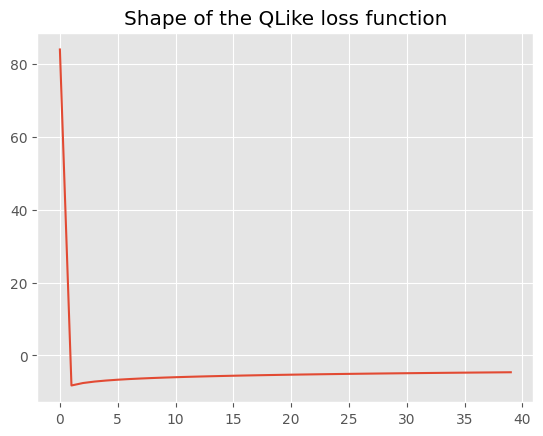

In [13]:
true = 1e-5 * np.ones(40)
pred = np.linspace(1e-7, 1e-2, 40)
q = qlike(true, pred)
plt.plot(q)
plt.title("Shape of the QLike loss function")
plt.show()

# Models

## HAR

In [14]:
class HAR():
  """
  Trains model for computing the third-order logarithmic HAR model for \
  realised variance (logHAR-RV(3)) at time t
  """

  def __init__(self, data, time, time_frame):
    """
    data -> represent the index data; data frame of variables: time, rv5, log \
            of realised variance for that day, for the previous one, the \
            previous week and previous month
    time -> time index of the first day not used in predicting
    time_frame -> rolling window length
    """
    self.data = data
    self.start = time - time_frame  # starting point
    self.end = time  # ending point
    # initialise variable that will be assigned later
    self.beta = -1 * np.zeros(4)
    self.sample_var = -1
    self.term = None

  def formula(self, row):
      "Actual formula used for forecasting; outputs single result"
      return np.exp(self.beta[0] + np.sqrt(self.sample_var) / 2) * np.power(row[0], self.beta[1]) * np.power(row[1], self.beta[2]) * np.power(row[2], self.beta[3])

  def _constructxy(self):
    "Returns logX, logY matrices needed to compute least squares"
    logY = self.data["log_t"].iloc[self.start:self.end].to_numpy()
    logXi = self.data[["log_prev_day", "log_prev_week", "log_prev_month"]].iloc[self.start:self.end].to_numpy()
    logX = np.c_[np.ones(self.end - self.start), logXi]
    return (logX, logY)

  def _ols_beta(self):
    "Returns ordinary least squares estimates for the model"
    X, Y = self._constructxy()
    return (X, Y, np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y))

  def model(self):
    "Returns the obtained parameters of the model: betas, sample variance"
    logX, logY, beta = self._ols_beta()
    residuals = logY - logX.dot(beta)  # compute residuals used for correction
    return (beta, np.var(residuals))

  def predict(self, key):
    "Predicts next day/week/month values of rv5 based on the developed logHAR(3) model"
    beta, sample_var = self.model()
    self.beta = beta
    self.sample_var = sample_var

    if key in {"d", "day"}:  # 1-day ahead prediction
      predict_array = np.exp(np.array([self.data[["log_prev_day", "log_prev_week", "log_prev_month"]].iloc[self.end].to_numpy()]))
      self.term = 1

    elif key in {"w", "week"}:  # 1-week ahead prediction
      predict_array = np.exp(self.data[["log_prev_day", "log_prev_week", "log_prev_month"]].iloc[self.end:self.end+5].to_numpy())
      self.term = 5

    elif key in {"m", "month"}:  # 1-month ahead prediction
      predict_array = np.exp(self.data[["log_prev_day", "log_prev_week", "log_prev_month"]].iloc[self.end:self.end+22].to_numpy())
      self.term = 22

    else:
      raise ValueError('Value of key must be "day"/"week"/"month"')

    return np.apply_along_axis(self.formula, axis=1, arr=predict_array)

  def loss(self, key, loss_type='both'):
    "Returns in-sample and out-of-sample squared error and QLIKE for the constructed model"
    beta, sample_var = self.model()
    self.beta = beta
    self.sample_var = sample_var

    in_sample_arr = np.exp(self.data[["log_prev_day", "log_prev_week", "log_prev_month"]].iloc[self.start:self.end].to_numpy())
    in_sample_pred = np.apply_along_axis(self.formula, axis=1, arr=in_sample_arr)
    real_in_data = np.array(self.data["rv5"].iloc[self.start:self.end])

    pred = self.predict(key)
    real_out_data = np.array(self.data["rv5"].iloc[self.end:self.end+self.term].to_numpy())

    if loss_type == 'mse':  # if only interested in squared loss
      in_sample_mse = (real_in_data - in_sample_pred) ** 2
      out_of_sample_mse = (real_out_data - pred) ** 2
      return [in_sample_mse, out_of_sample_mse]

    elif loss_type == 'qlike':  # if only interested in qlike loss
      in_sample_qlike = qlike(real_in_data, in_sample_pred)
      out_of_sample_qlike = qlike(real_out_data, pred)
      return [in_sample_qlike, out_of_sample_qlike]

    else:  # if interested in both the squared loss and the qlike loss
      in_sample_mse = (real_in_data - in_sample_pred) ** 2
      out_of_sample_mse = (real_out_data - pred) ** 2
      in_sample_qlike = qlike(real_in_data, in_sample_pred)
      out_of_sample_qlike = qlike(real_out_data, pred)
      return [in_sample_mse, in_sample_qlike, out_of_sample_mse, out_of_sample_qlike]


See if it is working well

##### Testing HAR

In [15]:
HAR(FTSE_data, 1300, 500).model()

(array([-0.9982136 ,  0.14082947,  0.44405911,  0.31907769]),
 0.25322792724205156)

In [16]:
HAR(FTSE_data, 1000, 500).predict('w')

array([3.28506898e-05, 2.05779648e-05, 3.08283568e-05, 2.76158854e-05,
       3.25840884e-05])

In [17]:
print(HAR(FTSE_data, 1000, 500).loss('w')[2])  # mse loss for out-of-sample predictions
print(np.mean((HAR(AEX_data, 1000, 500).loss('m', 'mse'))[0]))  # mean of the sqared errors
print(HAR(DAX_data, 1000, 500).loss('d', 'qlike')[1])  # qlike loss for out-of-sample prediction

[5.48633985e-10 1.23779717e-10 1.32144535e-10 3.78616701e-12
 2.02874408e-10]
3.2168636506266006e-08
[-7.933124]


## FNN_HAR

In [18]:
class FNN_HAR():
  """
  Train model to compute forecasts of a fully-connected feed-forward NN with \
  the same 3 inputs as the log-HAR model at time t
  """

  def __init__(self, data, time, time_frame):
    """
    data -> str: index of data we want to use (eg. '.FTSE', '.AEX')
    time -> int: index of first day not used in forecasting
    time_frame -> int: length of the rolling window for forecasting
    """

    self.data = data
    self.start = time - time_frame
    self.end = time
    with tf.device(device_name):
      self.model = None

    # initialize term to which assign value later
    self.term = -1

  def _architecture(self):
    "Define the model architecture"

    with tf.device(device_name):
      f = keras.Sequential([
      keras.layers.InputLayer(input_shape=(3,)),
      keras.layers.Dense(10, activation="relu"),
      keras.layers.Dense(10, activation="relu"),
      keras.layers.Dense(1, activation="linear")
      ])

      self.model = f

  def train(self):
    "Compile and fit the model"

    with tf.device(device_name):
      self._architecture()
      self.model.compile(optimizer="adam", loss="mean_squared_error")

    # particular inputs for fnn_har
    inputs = self.data[["log_prev_day", "log_prev_week", "log_prev_month"]].iloc[self.start:self.end]


    true_values = self.data["log_t"].iloc[self.start:self.end]
    self.model.fit(inputs, true_values, batch_size=100, epochs=20, verbose=False, validation_split=1/8)

  def forecast(self, key):
    "Returns the predicted rv5 for 1-day/1-week/1-month ahead forecast, where \
     'key' represents the type of forecast"

    if self.model == None:
      with tf.device(device_name):
        self.train()

    if key in {"d", "day"}:  # type of prediction: 1-day ahead
      # the predict_array represents the array with the inputs which we feed into the model for forecasting
      predict_array = np.array([self.data[["log_prev_day", "log_prev_week", "log_prev_month"]].iloc[self.end].to_numpy()])
      self.term = 1

    elif key in {"w", "week"}:  # 1-week ahead prediction
      predict_array = self.data[["log_prev_day", "log_prev_week", "log_prev_month"]].iloc[self.end:self.end+5].to_numpy()
      self.term = 5

    elif key in {"m", "month"}:  # 1-month ahead prediction
      predict_array = self.data[["log_prev_day", "log_prev_week", "log_prev_month"]].iloc[self.end:self.end+22].to_numpy()
      self.term = 22

    else:
      raise ValueError('Value of key must be "day"/"week"/"month"')

    return np.exp(self.model.predict(predict_array)).flatten()

  def loss(self, key, loss_type='both'):
    """
    Returns sequences of in-sample and out-of-sample squared error and QLIKE losses for the one trained model
    """

    if self.model == None:
      with tf.device(device_name):
        self.train()

    in_sample_arr = self.data[["log_prev_day", "log_prev_week", "log_prev_month"]].iloc[self.start:self.end].to_numpy()
    in_sample_pred = np.exp(self.model.predict(in_sample_arr)[0])  # the NN outputs logs of rv5
    true_in_sample = self.data["rv5"].iloc[self.start:self.end]

    out_of_sample_pred = self.forecast(key)  # forecast method takes care of the transformation
    true_out_of_sample = self.data["rv5"].iloc[self.end:self.end+self.term]

    if loss_type == 'mse':
      in_sample_mse = (true_in_sample - in_sample_pred) ** 2
      out_of_sample_mse = (true_out_of_sample - out_of_sample_pred) ** 2

      return [np.array([in_sample_mse]).flatten(), np.array([out_of_sample_mse]).flatten()]

    elif loss_type == 'qlike':
      in_sample_qlike = qlike(true_in_sample, in_sample_pred)
      out_of_sample_qlike = qlike(true_out_of_sample, out_of_sample_pred)

      return [np.array([in_sample_qlike]).flatten(), np.array([out_of_sample_qlike]).flatten()]

    else:  # if interested in both the squared error and the qlike loss
      in_sample_mse = (true_in_sample - in_sample_pred) ** 2
      out_of_sample_mse = (true_out_of_sample - out_of_sample_pred) ** 2

      in_sample_qlike = qlike(true_in_sample, in_sample_pred)
      out_of_sample_qlike = qlike(true_out_of_sample, out_of_sample_pred)

      return [np.array([in_sample_mse]).flatten(), np.array([in_sample_qlike]).flatten() , np.array([out_of_sample_mse]).flatten(), np.array([out_of_sample_qlike]).flatten()]

#### Testing FNN_HAR

In [19]:
# check if it is working properly
FNN_HAR(FTSE_data, 4200, 4100).forecast('w')

1/1 [==============================] - 0s 68ms/step


array([2.8532928e-05, 5.1554383e-05, 6.5182845e-05, 2.8065180e-05,
       2.8974022e-05], dtype=float32)

In [20]:
# check if it is working properly
FNN_HAR(AEX_data, 4700, 4600).loss('d', 'qlike')

1/1 [==============================] - 0s 39ms/step


[array([-7.58644768, -8.36378112, -7.39725069, ..., -8.93221133,
        -8.82565534, -8.85051903]),
 array([-9.43272323])]

In [21]:
# check if it is working properly
evaluations = FNN_HAR(DAX_data, 4300, 4000).loss('m', 'both')
for evaluation in evaluations:
  print(np.mean(evaluation))

1/1 [==============================] - 0s 46ms/step
1.0630744533868574e-07
-7.34724184014456
4.840291138991317e-10
-9.614704113952126


## FNN

In [22]:
class FNN():
  """
  Trains model to compute forecasts of a fully-connected feed-forward NN directly on data
  """

  def __init__(self, data, time, time_frame):
    """
    data -> str: index of data we want to use (eg. '.FTSE', '.AEX')
    time -> int: index of first day not used in forecasting
    time_frame -> int: length of the rolling window for forecasting
    """

    self.data = data
    self.start = time - time_frame
    self.end = time
    with tf.device(device_name):
      self.model = None

    # initialize term to which assign value later
    self.term = -1

  def _architecture(self):
    "Define the model architecture"

    with tf.device(device_name):
      # feed-forward NN directly on data
      f = keras.Sequential([
        keras.layers.InputLayer(input_shape=(22,)),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(1, activation="linear")
        ])

      self.model = f

  def train(self):
    "Compile and fit the model"

    with tf.device(device_name):
      self._architecture()
      self.model.compile(optimizer="adam", loss="mean_squared_error")

    # the inputs are logs of past realised variance
    inputs = np.array([self.data[["log_t"]].to_numpy().flatten()[i-22:i] for i in range(self.start, self.end)])  # change input size if needed


    true_values = self.data["log_t"].iloc[self.start:self.end]
    self.model.fit(inputs, true_values, batch_size=100, epochs=20, verbose=False, validation_split=1/8)

  def forecast(self, key):
    "Returns the predicted rv5 for 1-day/1-week/1-month ahead forecast, where \
     'key' represents the type of forecast"

    if self.model == None:
      with tf.device(device_name):
        self.train()

    if key in {"d", "day"}:
      # the predict_array represents the array with the inputs which we feed into the model for forecasting
      predict_array = np.array([self.data[["log_t"]].iloc[self.end-22: self.end]])
      self.term = 1

    elif key in {"w", "week"}:
      predict_array = np.array([self.data[["log_t"]].iloc[i-22:i] for i in range(self.end,self.end+5)])
      self.term = 5

    elif key in {"m", "month"}:
      predict_array = np.array([self.data[["log_t"]].iloc[i-22:i] for i in range(self.end,self.end+22)])
      self.term = 22

    else:
      raise ValueError('Value of key must be "day"/"week"/"month"')

    return np.exp(self.model.predict(predict_array)).flatten()

  def loss(self, key, loss_type='both'):
    """
    Returns sequences of in-sample and out-of-sample squared error and QLIKE losses for the one trained model
    """

    if self.model == None:
      with tf.device(device_name):
        self.train()

    in_sample_arr = np.array([self.data[["log_t"]].iloc[i-22:i] for i in range(self.start,self.end)])
    in_sample_pred = np.exp(self.model.predict(in_sample_arr)[0])  # the NN outputs logs of rv5
    true_in_sample = self.data["rv5"].iloc[self.start:self.end].to_numpy()

    out_of_sample_pred = self.forecast(key)
    true_out_of_sample = self.data["rv5"].iloc[self.end:self.end+self.term].to_numpy()

    if loss_type == 'mse':
      in_sample_mse = (true_in_sample - in_sample_pred) ** 2
      out_of_sample_mse = (true_out_of_sample - out_of_sample_pred) ** 2

      return [np.array([in_sample_mse]).flatten(), np.array([out_of_sample_mse]).flatten()]

    elif loss_type == 'qlike':
      in_sample_qlike = qlike(true_in_sample, in_sample_pred)
      out_of_sample_qlike = qlike(true_out_of_sample, out_of_sample_pred)

      return [np.array([in_sample_qlike]).flatten(), np.array([out_of_sample_qlike]).flatten()]

    else:
      in_sample_mse = (true_in_sample - in_sample_pred) ** 2
      out_of_sample_mse = (true_out_of_sample - out_of_sample_pred) ** 2

      in_sample_qlike = qlike(true_in_sample, in_sample_pred)
      out_of_sample_qlike = qlike(true_out_of_sample, out_of_sample_pred)

      return [np.array([in_sample_mse]).flatten(), np.array([in_sample_qlike]).flatten() , np.array([out_of_sample_mse]).flatten(), np.array([out_of_sample_qlike]).flatten()]

#### Testing FNN

In [23]:
# check if it is working well
FNN(FTSE_data, 4200, 4100).forecast('w')

1/1 [==============================] - 0s 103ms/step


array([2.4183477e-05, 3.1104129e-05, 5.2372845e-05, 3.7338235e-05,
       2.9305775e-05], dtype=float32)

In [24]:
# check if it is working properly
FNN(AEX_data, 4700, 4600).loss('d', 'qlike')

1/1 [==============================] - 0s 29ms/step


[array([-7.53069608, -8.38335746, -7.32316484, ..., -9.00687172,
        -8.88998986, -8.91726298]),
 array([-9.41184605])]

In [25]:
# check if it is working properly
evaluations = FNN(DAX_data, 4300, 4000).loss('m', 'both')
for evaluation in evaluations:
  print(np.mean(evaluation))

1/1 [==============================] - 0s 119ms/step
1.0397018219840224e-07
-7.465322165232613
4.5058327599425054e-10
-9.589717215717364


## CNN

In [26]:
class CNN():
  """
  Trains model to compute forecasts of a convolutional feed-forward NN directly on data
  """

  def __init__(self, data, time, time_frame):
    """
    data -> str: index of data we want to use (eg. '.FTSE', '.AEX')
    time -> int: index of first day not used in forecasting
    time_frame -> int: length of the rolling window for forecasting
    """

    self.data = data
    self.start = time - time_frame
    self.end = time
    with tf.device(device_name):
      self.model = None

    # initialize term to which assign value later
    self.term = -1

  def _architecture(self):
    "Define the model architecture"

    # convolutional NN on data
    with tf.device('/GPU:0'):
      f = keras.Sequential([
        keras.layers.Conv1D(filters=64, kernel_size=3, strides=3, activation='relu', input_shape=(22, 1)),
        keras.layers.Flatten(),
        keras.layers.Dense(50, activation='relu'),
        keras.layers.Dense(50, activation='relu'),
        keras.layers.Dense(1, activation="linear")
        ])

      self.model = f

  def train(self):
    "Compile and fit the model"

    with tf.device(device_name):
      self._architecture()
      self.model.compile(optimizer="adam", loss="mean_squared_error")


    inputs = np.array([self.data[["log_t"]].iloc[i-22:i] for i in range(self.start, self.end)])


    true_values = self.data["log_t"].iloc[self.start:self.end]
    self.model.fit(inputs, true_values, batch_size=100, epochs=20, verbose=False, validation_split=1/8)

  def forecast(self, key):
    "Returns the predicted rv5 for 1-day/1-week/1-month ahead forecast, where \
     'key' represents the type of forecast"

    if self.model == None:
      with tf.device(device_name):
        self.train()

    if key in {"d", "day"}:
      # the predict_array represents the array with the inputs which we feed into the model for forecasting
      predict_array = np.array([self.data[["log_t"]].iloc[self.end-22: self.end]])
      self.term = 1

    elif key in {"w", "week"}:
      predict_array = np.array([self.data[["log_t"]].iloc[i-22:i] for i in range(self.end,self.end+5)])
      self.term = 5

    elif key in {"m", "month"}:
      predict_array = np.array([self.data[["log_t"]].iloc[i-22:i] for i in range(self.end,self.end+22)])
      self.term = 22

    else:
      raise ValueError('Value of key must be "day"/"week"/"month"')

    return np.exp(self.model.predict(predict_array)).flatten()

  def loss(self, key, loss_type='both'):
    """
    Returns sequences of in-sample and out-of-sample squared error and QLIKE losses for the one trained model
    """

    if self.model == None:
      with tf.device(device_name):
        self.train()

    in_sample_arr = np.array([self.data[["log_t"]].iloc[i-22:i] for i in range(self.start,self.end)])
    in_sample_pred = np.exp(self.model.predict(in_sample_arr)[0])  # the NN outputs logs of rv5
    true_in_sample = self.data["rv5"].iloc[self.start:self.end]

    out_of_sample_pred = self.forecast(key)
    true_out_of_sample = self.data["rv5"].iloc[self.end:self.end+self.term]

    if loss_type == 'mse':
      in_sample_mse = (true_in_sample - in_sample_pred) ** 2
      out_of_sample_mse = (true_out_of_sample - out_of_sample_pred) ** 2

      return [np.array([in_sample_mse]).flatten(), np.array([out_of_sample_mse]).flatten()]

    elif loss_type == 'qlike':
      in_sample_qlike = qlike(true_in_sample, in_sample_pred)
      out_of_sample_qlike = qlike(true_out_of_sample, out_of_sample_pred)

      return [np.array([in_sample_qlike]).flatten(), np.array([out_of_sample_qlike]).flatten()]

    else:
      in_sample_mse = (true_in_sample - in_sample_pred) ** 2
      out_of_sample_mse = (true_out_of_sample - out_of_sample_pred) ** 2

      in_sample_qlike = qlike(true_in_sample, in_sample_pred)
      out_of_sample_qlike = qlike(true_out_of_sample, out_of_sample_pred)

      return [np.array([in_sample_mse]).flatten(), np.array([in_sample_qlike]).flatten() , np.array([out_of_sample_mse]).flatten(), np.array([out_of_sample_qlike]).flatten()]

#### Testing CNN

In [27]:
# check if it is working well
CNN(FTSE_data, 4200, 4100).forecast('w')

1/1 [==============================] - 0s 90ms/step


array([3.7222220e-05, 3.8053717e-05, 3.8209433e-05, 3.9254523e-05,
       3.6815949e-05], dtype=float32)

In [28]:
# check if it is working properly
CNN(AEX_data, 4700, 4600).loss('d', 'qlike')

1/1 [==============================] - 0s 51ms/step


[array([-7.60127735, -8.35623181, -7.41752723, ..., -8.90829724,
        -8.80480893, -8.82895681]),
 array([-9.42953746])]

In [29]:
# check if it is working properly
evaluations = CNN(DAX_data, 4300, 4000).loss('m', 'both')
for evaluation in evaluations:
  print(np.mean(evaluation))

1/1 [==============================] - 0s 93ms/step
1.0187337305226051e-07
-7.544821649482004
5.634102694743578e-10
-9.551069135040505


## LSTM

In [30]:
class LSTM():
  """
  Trains model to compute forecasts of an LSTM recurrent NN
  """

  def __init__(self, data, time, time_frame):
    """
    data -> str: index of data we want to use (eg. '.FTSE', '.AEX')
    time -> int: index of first day not used in forecasting
    time_frame -> int: length of the rolling window for forecasting
    """

    self.data = data
    self.start = time - time_frame
    self.end = time
    with tf.device(device_name):
      self.model = None

    # initialize term to which assign value later
    self.term = -1

  def _architecture(self):
    "Define the model architecture"

    # long short term memory architecture (recurrent neural network)
    with tf.device('/GPU:0'):
      f = keras.Sequential([
        keras.layers.LSTM(20, return_sequences=True, input_shape=(22,1)),
        keras.layers.LSTM(20),
        keras.layers.Dense(1)  # output layer, linear activation
        ])

      self.model = f

  def train(self):
    "Compile and fit the model"

    with tf.device(device_name):
      self._architecture()

    inputs = np.array([self.data[["log_t"]].iloc[i-22:i] for i in range(self.start, self.end)])
    true_values = self.data["log_t"].iloc[self.start:self.end]

    lr = 0.005  # learning rate

    # Create an instance of the Adam optimizer with the desired learning rate
    optim = keras.optimizers.Adam(learning_rate=lr)

    ep = 30  # number of epochs

    for i in range(int(ep / 10)):

      # Compile the model
      with tf.device(device_name):
        self.model.compile(optimizer=optim, loss='mse')
      self.model.fit(inputs, true_values, batch_size=100, epochs=10, verbose=False, validation_split=1/8)

  def forecast(self, key):
    "Returns the predicted rv5 for 1-day/1-week/1-month ahead forecast, where \
     'key' represents the type of forecast"

    if self.model == None:
      with tf.device(device_name):
        self.train()

    if key in {"d", "day"}:
      # the predict_array represents the array with the inputs which we feed into the model for forecasting
      predict_array = np.array([self.data[["log_t"]].iloc[self.end-22: self.end]])
      self.term = 1

    elif key in {"w", "week"}:
      predict_array = np.array([self.data[["log_t"]].iloc[i-22:i] for i in range(self.end,self.end+5)])
      self.term = 5

    elif key in {"m", "month"}:
      predict_array = np.array([self.data[["log_t"]].iloc[i-22:i] for i in range(self.end,self.end+22)])
      self.term = 22

    else:
      raise ValueError('Value of key must be "day"/"week"/"month"')

    return np.exp(self.model.predict(predict_array)).flatten()

  def loss(self, key, loss_type='both'):
    """
    Returns sequences of in-sample and out-of-sample squared error and QLIKE losses for the one trained model
    """

    if self.model == None:
      with tf.device(device_name):
        self.train()

    in_sample_arr = np.array([self.data[["log_t"]].iloc[i-22:i] for i in range(self.start,self.end)])
    in_sample_pred = np.exp(self.model.predict(in_sample_arr)[0])  # the NN outputs logs of rv5
    true_in_sample = self.data["rv5"].iloc[self.start:self.end]

    out_of_sample_pred = self.forecast(key)
    true_out_of_sample = self.data["rv5"].iloc[self.end:self.end+self.term]

    if loss_type == 'mse':
      in_sample_mse = (true_in_sample - in_sample_pred) ** 2
      out_of_sample_mse = (true_out_of_sample - out_of_sample_pred) ** 2

      return [np.array([in_sample_mse]).flatten(), np.array([out_of_sample_mse]).flatten()]

    elif loss_type == 'qlike':
      in_sample_qlike = qlike(true_in_sample, in_sample_pred)
      out_of_sample_qlike = qlike(true_out_of_sample, out_of_sample_pred)

      return [np.array([in_sample_qlike]).flatten(), np.array([out_of_sample_qlike]).flatten()]

    else:
      in_sample_mse = (true_in_sample - in_sample_pred) ** 2
      out_of_sample_mse = (true_out_of_sample - out_of_sample_pred) ** 2

      in_sample_qlike = qlike(true_in_sample, in_sample_pred)
      out_of_sample_qlike = qlike(true_out_of_sample, out_of_sample_pred)

      return [np.array([in_sample_mse]).flatten(), np.array([in_sample_qlike]).flatten() , np.array([out_of_sample_mse]).flatten(), np.array([out_of_sample_qlike]).flatten()]

#### Testing LSTM

In [31]:
# check if it is working well
LSTM(FTSE_data, 4200, 4100).forecast('w')

1/1 [==============================] - 1s 586ms/step


array([3.5483434e-05, 4.2060412e-05, 5.3890566e-05, 4.6780984e-05,
       4.0527178e-05], dtype=float32)

In [32]:
# check if it is working properly
LSTM(AEX_data, 4700, 4600).loss('d', 'qlike')

1/1 [==============================] - 0s 26ms/step


[array([-7.59899829, -8.35747802, -7.41439014, ..., -8.91212133,
        -8.80814979, -8.83241042]),
 array([-9.43338415])]

In [33]:
# check if it is working properly
evaluations = LSTM(DAX_data, 4300, 4000).loss('m', 'both')
for evaluation in evaluations:
  print(np.mean(evaluation))

1/1 [==============================] - 1s 952ms/step
1.079039217077389e-07
-7.24440083672246
4.3148880438634327e-10
-9.59418531177762


## GRU

In [34]:
class GRU():
  """
  Trains model to compute forecasts of a GRU recurrent NN
  """

  def __init__(self, data, time, time_frame):
    """
    data -> str: index of data we want to use (eg. '.FTSE', '.AEX')
    time -> int: index of first day not used in forecasting
    time_frame -> int: length of the rolling window for forecasting
    """

    self.data = data
    self.start = time - time_frame
    self.end = time
    with tf.device(device_name):
      self.model = None

    # initialize term to which assign value later
    self.term = -1

  def _architecture(self):
    "Define the model architecture"

    # gated recurrent unit (GRU)
    with tf.device('/GPU:0'):
      f = keras.Sequential([
        keras.layers.GRU(20, return_sequences=True, input_shape=(22,1)),
        keras.layers.GRU(20),
        keras.layers.Dense(1)  # output layer, linear activation
        ])

      self.model = f

  def train(self):
    "Compile and fit the model"

    with tf.device(device_name):
      self._architecture()

    inputs = np.array([self.data[["log_t"]].iloc[i-22:i] for i in range(self.start, self.end)])
    true_values = self.data["log_t"].iloc[self.start:self.end]

    lr = 0.005  # learning rate

    # Create an instance of the Adam optimizer with the desired learning rate
    optim = keras.optimizers.Adam(learning_rate=lr)

    ep = 30  # number of epochs

    for i in range(int(ep / 10)):

      # Compile the model
      with tf.device(device_name):
        self.model.compile(optimizer=optim, loss='mse')
      self.model.fit(inputs, true_values, batch_size=100, epochs=10, verbose=False, validation_split=1/8)

  def forecast(self, key):
    "Returns the predicted rv5 for 1-day/1-week/1-month ahead forecast, where \
     'key' represents the type of forecast"

    if self.model == None:
      with tf.device(device_name):
        self.train()

    if key in {"d", "day"}:
      # the predict_array represents the array with the inputs which we feed into the model for forecasting
      predict_array = np.array([self.data[["log_t"]].iloc[self.end-22: self.end]])
      self.term = 1

    elif key in {"w", "week"}:
      predict_array = np.array([self.data[["log_t"]].iloc[i-22:i] for i in range(self.end,self.end+5)])
      self.term = 5

    elif key in {"m", "month"}:
      predict_array = np.array([self.data[["log_t"]].iloc[i-22:i] for i in range(self.end,self.end+22)])
      self.term = 22

    else:
      raise ValueError('Value of key must be "day"/"week"/"month"')

    return np.exp(self.model.predict(predict_array)).flatten()

  def loss(self, key, loss_type='both'):
    """
    Returns sequences of in-sample and out-of-sample squared error and QLIKE losses for the one trained model
    """

    if self.model == None:
      with tf.device(device_name):
        self.train()

    in_sample_arr = np.array([self.data[["log_t"]].iloc[i-22:i] for i in range(self.start,self.end)])
    in_sample_pred = np.exp(self.model.predict(in_sample_arr)[0])  # the NN outputs logs of rv5
    true_in_sample = self.data["rv5"].iloc[self.start:self.end]

    out_of_sample_pred = self.forecast(key)
    true_out_of_sample = self.data["rv5"].iloc[self.end:self.end+self.term]

    if loss_type == 'mse':
      in_sample_mse = (true_in_sample - in_sample_pred) ** 2
      out_of_sample_mse = (true_out_of_sample - out_of_sample_pred) ** 2

      return [np.array([in_sample_mse]).flatten(), np.array([out_of_sample_mse]).flatten()]

    elif loss_type == 'qlike':
      in_sample_qlike = qlike(true_in_sample, in_sample_pred)
      out_of_sample_qlike = qlike(true_out_of_sample, out_of_sample_pred)

      return [np.array([in_sample_qlike]).flatten(), np.array([out_of_sample_qlike]).flatten()]

    else:
      in_sample_mse = (true_in_sample - in_sample_pred) ** 2
      out_of_sample_mse = (true_out_of_sample - out_of_sample_pred) ** 2

      in_sample_qlike = qlike(true_in_sample, in_sample_pred)
      out_of_sample_qlike = qlike(true_out_of_sample, out_of_sample_pred)

      return [np.array([in_sample_mse]).flatten(), np.array([in_sample_qlike]).flatten() , np.array([out_of_sample_mse]).flatten(), np.array([out_of_sample_qlike]).flatten()]

#### Testing GRU

In [35]:
# check if it is working well
GRU(FTSE_data, 4200, 4100).forecast('w')

1/1 [==============================] - 1s 514ms/step


array([3.0729501e-05, 3.8516606e-05, 4.9371378e-05, 3.8243994e-05,
       3.5208170e-05], dtype=float32)

In [36]:
# check if it is working properly
GRU(AEX_data, 4700, 4600).loss('d', 'qlike')

1/1 [==============================] - 0s 28ms/step


[array([-7.62356802, -8.34199798, -7.44870769, ..., -8.86735462,
        -8.76887305, -8.79185266]),
 array([-9.43054002])]

In [37]:
# check if it is working properly
evaluations = GRU(DAX_data, 4300, 4000).loss('m', 'both')
for evaluation in evaluations:
  print(np.mean(evaluation))

1/1 [==============================] - 1s 763ms/step
1.0691731460435465e-07
-7.310337570665485
4.813244399725918e-10
-9.58104445194008


# Implement function to evaluate the squared error and QLIKE losses for entire period of time

In [38]:
class Evaluate():
  """
  Given a model used for forecasting and the set of the actual values of data, \
  returns sequences of losses for all days after the initial training window
  """

  def __init__(self, data, model, key, window):
    """
    data -> actual values
    model -> eg. HAR class (must have method 'predict')
    key -> type of forecast: day/week/month
    window -> the length of the rolling window
    """
    self.data = data
    self.model = model
    self.key = key
    self.window = window

  def split2(self, lists):
    "Given a list of lists of 2 arrays, returns concatenations done on columns"

    arr1, arr2 = np.array([]), np.array([])  # initalize empty arrays

    for sublist in lists:
      arr1 = np.append(arr1, sublist[0])
      arr2 = np.append(arr2, sublist[1])

    return [arr1, arr2]

  def split4(self, lists):
    "Given a list of lists of 4 arrays, returns concatenations done on columns"

    # Initalize empty arrays
    arr1, arr2, arr3, arr4 = np.array([]), np.array([]), np.array([]), np.array([])

    for sublist in lists:
      arr1 = np.append(arr1, sublist[0])
      arr2 = np.append(arr2, sublist[1])
      arr3 = np.append(arr3, sublist[2])
      arr4 = np.append(arr4, sublist[3])

    return [arr1, arr2, arr3, arr4]

  def _pred_indices(self):
    "Returns the indices where we need to fit model"
    if self.key in {"d", "day"}:
      prediction_indices = np.arange(self.window + 1, len(self.data) - 1)
      term = 1
    elif self.key in {"w", "week"}:
      prediction_indices = np.arange(self.window + 5, len(self.data) - 5, 5)
      term = 5
    elif self.key in {"m", "month"}:
      prediction_indices = np.arange(self.window + 22, len(self.data) - 22, 22)
      term = 22
    else:
      raise ValueError('Value of key must be "day"/"week"/"month"')

    return (prediction_indices, term)

  def total(self, loss_type='both'):

    prediction_indices, term = self._pred_indices()

    loss_list = [self.model(self.data, ind, self.window).loss(self.key, loss_type) for ind in prediction_indices]

    if loss_type in {'mse', 'qlike'}:
      return self.split2(loss_list)

    else:
      return self.split4(loss_list)

  def partial_evaluate_indices(self, partial_start, partial_stop):
    "Evaluates model only in the specified time interval"
    if self.key in {"d", "day"}:
      prediction_indices = np.arange(partial_start, partial_stop)
      term = 1
    elif self.key in {"w", "week"}:
      prediction_indices = np.arange(partial_start, partial_stop, 5)
      term = 5
    elif self.key in {"m", "month"}:
      prediction_indices = np.arange(partial_start, partial_stop, 22)
      term = 22
    else:
      raise ValueError('Value of key must be "day"/"week"/"month"')

    return (prediction_indices, term)

  def partial(self, partial_start, partial_stop, loss_type='both'):
    "Returns the sequences of loss differentials for the specified time interval"

    partial_ind, term = self.partial_evaluate_indices(partial_start, partial_stop)

    loss_list = [self.model(self.data, ind, self.window).loss(self.key, loss_type) for ind in partial_ind]

    if loss_type in {'mse', 'qlike'}:
      return self.split2(loss_list)

    else:
      return self.split4(loss_list)

#### Test the partial evaluation method

In [39]:
# Check if it is working well
evaluations = Evaluate(FTSE_data, HAR, "d", 3000).partial(4100, 4110, 'both')
print(evaluations)
for evaluation in evaluations:
  print(np.mean(evaluation))

[array([7.48004060e-10, 1.62303283e-09, 4.01545457e-11, ...,
       5.53843925e-09, 1.35021128e-09, 1.03241969e-10]), array([-8.31051892, -9.13931359, -9.02448997, ..., -8.74977482,
       -9.04568664, -8.84078283]), array([1.69041100e-09, 1.18983962e-09, 2.03673792e-09, 4.31358045e-09,
       2.37004535e-09, 1.67755684e-08, 5.55256022e-09, 1.35334497e-09,
       1.02852519e-10, 2.75018629e-10]), array([-8.80857077, -8.861308  , -7.91133232, -8.82469426, -9.24959023,
       -6.44730898, -8.7492203 , -9.04538597, -8.84083251, -8.76718595])]
5.4573484746170226e-08
-8.47342304513151
3.565995912080368e-09
-8.550542929558123


In [40]:
# check if it is working well
evaluations =  Evaluate(AEX_data, FNN_HAR, 'm', 4400).partial(4500, 4510,'both')
print(evaluations)
for evaluation in evaluations:
  print(np.mean(evaluation))

1/1 [==============================] - 0s 17ms/step
[array([4.79663335e-09, 2.60698984e-10, 8.10799158e-09, ...,
       4.93616599e-09, 5.40975964e-09, 7.32603299e-09]), array([-7.52137419, -8.3856429 , -7.31101782, ..., -8.93324116,
       -8.96656777, -9.08842186]), array([5.75836781e-11, 1.94227004e-10, 5.78738848e-11, 6.83668923e-11,
       4.22304107e-10, 4.01645089e-10, 4.13433442e-11, 4.45765601e-12,
       2.30224418e-11, 5.85193419e-11, 1.40172352e-11, 9.76408132e-11,
       7.08754783e-11, 6.50760139e-11, 3.05676928e-11, 8.86479637e-12,
       9.08966833e-12, 3.37110486e-11, 1.89722163e-10, 2.71491738e-11,
       1.08118978e-11, 7.35856598e-13]), array([ -9.52477577, -10.20576793,  -9.6151572 ,  -9.32744297,
        -8.7531976 ,  -9.82824233, -10.27341255, -10.22811528,
       -10.3256496 ,  -9.60261256,  -9.88766868,  -9.32690382,
        -9.86578929, -10.28220723, -10.55461921, -10.57567342,
       -10.05516889,  -9.64098019, -10.37689262, -10.83033187,
       -10.846953  ,

In [41]:
# Check if it is working well
evaluations = Evaluate(FTSE_data, FNN, "d", 3000).partial(4100, 4110, 'both')
print(evaluations)
for evaluation in evaluations:
  print(np.mean(evaluation))

1/1 [==============================] - 0s 17ms/step
[array([1.76337384e-09, 1.11159546e-10, 1.23789377e-11, ...,
       6.44050527e-11, 2.57716527e-11, 4.88779020e-10]), array([-8.07726133, -9.37765202, -9.02959265, ..., -9.13839415,
       -9.23556434, -8.67430619]), array([9.77791825e-10, 1.59829959e-11, 3.11104360e-09, 1.62955032e-09,
       1.10371652e-09, 1.71747911e-08, 9.87247979e-10, 6.58372225e-10,
       9.85185982e-12, 2.05305966e-10]), array([-8.86033684, -8.99013153, -7.78955115, -8.99009816, -9.41004711,
       -6.37882206, -9.02020419, -9.1233865 , -8.85391665, -8.74922614])]
9.65467035166675e-08
-6.944331189268673
2.5873654371265837e-09
-8.616572032114245


In [42]:
# Check if it is working well
evaluations = Evaluate(FTSE_data, CNN, "d", 3000).partial(4100, 4110, 'both')
print(evaluations)
for evaluation in evaluations:
  print(np.mean(evaluation))

1/1 [==============================] - 0s 17ms/step
[array([2.13257431e-09, 4.03982747e-11, 5.93767412e-11, ...,
       5.96961383e-15, 9.15643577e-12, 1.96162662e-10]), array([-7.95086308, -9.40161728, -9.01331199, ..., -9.16820734,
       -9.24489999, -8.80192078]), array([5.92089474e-10, 1.24658629e-09, 2.21295671e-09, 1.77110717e-09,
       3.24306634e-09, 1.35015008e-08, 1.10245390e-09, 9.93006839e-10,
       2.09708823e-10, 1.00026032e-11]), array([-8.89502766, -8.85693984, -7.89393553, -8.97851119, -9.17128262,
       -6.88811768, -9.00867535, -9.08258954, -8.82813096, -8.79703187])]
9.614964007720868e-08
-7.136996045014239
2.4882478894600586e-09
-8.640024224706725


In [43]:
# Check if it is working well
evaluations = Evaluate(FTSE_data, LSTM, "d", 3000).partial(4100, 4110, 'both')
print(evaluations)
for evaluation in evaluations:
  print(np.mean(evaluation))

1/1 [==============================] - 0s 27ms/step
[array([1.89504638e-09, 8.10654864e-11, 2.55829271e-11, ...,
       1.34304244e-10, 7.46543305e-11, 6.59053751e-10]), array([-8.03531655, -9.38722659, -9.02537768, ..., -9.09506563,
       -9.20516559, -8.56922471]), array([3.71252741e-10, 1.90134559e-11, 1.84110819e-09, 1.03281263e-09,
       1.07796445e-09, 1.47711448e-08, 1.70482982e-10, 6.45306340e-10,
       9.41575593e-11, 1.96168305e-10]), array([-8.91852788, -8.9895224 , -7.92957296, -9.04574874, -9.41432234,
       -6.73942213, -9.12921787, -9.12514489, -8.84194983, -8.75189637])]
9.606739763102108e-08
-7.049378088213517
2.0219411451001767e-09
-8.68853254072722


In [44]:
# Check if it is working well
evaluations = Evaluate(FTSE_data, GRU, "d", 3000).partial(4100, 4110, 'both')
print(evaluations)
for evaluation in evaluations:
  print(np.mean(evaluation))

1/1 [==============================] - 0s 18ms/step
[array([2.15622655e-09, 3.72170915e-11, 6.33777274e-11, ...,
       5.90392825e-11, 2.24202758e-11, 4.73792443e-10]), array([-7.94178077, -9.40283877, -9.01177558, ..., -9.14127541,
       -9.23736402, -8.68235311]), array([2.26171377e-10, 5.01393635e-11, 3.01136689e-09, 1.80116086e-09,
       7.46257658e-10, 2.05479228e-08, 8.93259291e-10, 3.19562974e-10,
       7.84743028e-12, 2.46575776e-12]), array([-8.93629344, -8.98365557, -7.80254292, -8.97611507, -9.4758041 ,
       -5.60174237, -9.03006713, -9.17500006, -8.85424287, -8.79815274])]
9.706749906944412e-08
-6.755879627119834
2.7606154418411794e-09
-8.56336162690356


#### Test the total evaluation method

In [45]:
# Check if it is working well
evaluations =  Evaluate(DAX_data, HAR, 'm', 4400).total('both')
print(evaluations)
for evaluation in evaluations:
  print(np.mean(evaluation))

[array([6.51916656e-08, 2.58883220e-10, 4.96520877e-08, ...,
       1.37085481e-10, 3.21095489e-11, 1.93439589e-10]), array([ -7.15912233,  -6.85153723,  -6.20702165, ..., -10.32636652,
       -10.18733967, -10.46895068]), array([7.19139408e-10, 2.58726224e-10, 1.40236262e-10, ...,
       1.35064627e-09, 4.17762832e-12, 1.66746614e-10]), array([-9.49489489, -8.84778199, -9.2795719 , ..., -9.36417858,
       -9.03761743, -8.59363404])]
3.4566794476046335e-08
-8.277486333121304
1.4395505754683107e-08
-8.789920954714846


In [46]:
# check if it is working well
evaluations =  Evaluate(AEX_data, FNN_HAR, 'm', 5500).total('both')
print(evaluations)
for evaluation in evaluations:
  print(np.mean(evaluation))

1/1 [==============================] - 0s 16ms/step
[array([2.97261483e-09, 5.46953867e-09, 1.44370327e-08, ...,
       4.73339154e-10, 4.24436056e-09, 2.08292862e-12]), array([-8.44111319, -7.4005364 , -7.02636784, ..., -7.94904386,
       -7.53853557, -8.16852069]), array([2.00929636e-10, 1.06886097e-11, 5.16606193e-10, 1.07204285e-10,
       6.17829268e-12, 3.56025473e-11, 8.85335016e-09, 1.33706689e-14,
       1.97317659e-10, 8.16331452e-11, 2.36704120e-11, 3.12757593e-12,
       8.94144005e-09, 8.16355161e-10, 1.07196398e-10, 4.19486689e-10,
       1.53250914e-11, 1.23941649e-11, 4.55506423e-10, 1.09238107e-09,
       2.70758420e-13, 1.89481024e-08, 1.95685193e-08, 4.40412705e-09,
       7.06378466e-11, 5.57052870e-09, 4.06735603e-10, 4.40525189e-11,
       6.44323766e-12, 1.61586119e-08, 3.25765483e-11, 1.34153190e-09,
       1.61138177e-09, 1.78375114e-09, 2.58265492e-09, 4.11198715e-10,
       5.31162665e-12, 2.24536751e-10, 1.16991990e-09, 1.52189548e-09,
       9.12357084e-10

In [47]:
evaluations =  Evaluate(DAX_data, FNN, 'm', 5500).total('both')
print(evaluations)
for evaluation in evaluations:
  print(np.mean(evaluation))

1/1 [==============================] - 0s 26ms/step
[array([6.69383448e-09, 6.04179048e-09, 1.33504774e-07, ...,
       1.15612305e-07, 1.13075550e-07, 1.17437158e-07]), array([-7.33849883, -6.82561172, -5.90089297, ..., -7.93278665,
       -7.92204919, -7.94043812]), array([7.99442919e-11, 3.41325887e-11, 5.02360160e-11, 2.84112046e-10,
       9.41793517e-11, 2.37235232e-11, 5.35949643e-12, 2.76128242e-13,
       1.57770488e-09, 1.60560107e-10, 3.36878988e-11, 1.27169072e-10,
       1.11325667e-11, 3.10527900e-16, 5.93158695e-11, 2.23727678e-11,
       1.58183775e-11, 5.44759931e-11, 2.73278555e-14, 2.31971175e-11,
       1.89532119e-12, 1.76970110e-11, 4.11155837e-12, 3.65720156e-09,
       1.81006869e-12, 1.14000664e-09, 1.13807115e-09, 8.97490105e-10,
       1.59103821e-08, 4.37333992e-09, 3.18277208e-08, 1.70889851e-09,
       1.24228134e-12, 5.43602139e-10, 3.97846518e-10, 1.77649475e-09,
       3.48804359e-11, 1.43443808e-09, 9.53676090e-10, 1.32935108e-10,
       5.02659166e-12

In [48]:
evaluations =  Evaluate(DAX_data, CNN, 'm', 5500).total('both')
print(evaluations)
for evaluation in evaluations:
  print(np.mean(evaluation))

1/1 [==============================] - 0s 18ms/step
[array([1.70694501e-08, 8.34904080e-10, 1.00203145e-07, ...,
       8.55391454e-08, 8.33590918e-08, 8.71098145e-08]), array([-7.29267854, -6.84938304, -6.05013571, ..., -8.0748889 ,
       -8.06245975, -8.08374587]), array([4.38654746e-10, 9.58247464e-11, 1.86902652e-10, 6.76000804e-11,
       2.68838211e-10, 1.18231213e-10, 3.83806347e-11, 7.36678478e-11,
       8.70468695e-10, 2.30692521e-10, 3.98297328e-10, 3.96473122e-10,
       1.78737473e-10, 1.40751683e-10, 2.08024297e-10, 1.73715788e-11,
       2.92778380e-13, 1.13442830e-11, 2.65139228e-11, 5.07083689e-11,
       1.45083441e-11, 1.09407426e-10, 6.11063366e-12, 3.92071469e-09,
       1.87474055e-10, 1.08796200e-09, 2.24952132e-09, 1.02019976e-10,
       1.44275002e-08, 1.09045296e-08, 3.87156657e-08, 7.15172757e-12,
       1.39748833e-09, 1.51114765e-09, 5.62940033e-10, 1.92254270e-09,
       8.22492599e-11, 1.77295910e-10, 1.17327459e-09, 1.40313369e-10,
       3.83518560e-11

In [49]:
evaluations =  Evaluate(DAX_data, LSTM, 'm', 5500).total('both')
print(evaluations)
for evaluation in evaluations:
  print(np.mean(evaluation))

1/1 [==============================] - 0s 19ms/step
[array([1.42646643e-08, 1.60881551e-09, 1.07429331e-07, ...,
       7.28169239e-08, 7.08066010e-08, 7.42666435e-08]), array([-7.30384805, -6.84629434, -6.02133992, ..., -8.1503126 ,
       -8.13687614, -8.15988737]), array([9.80077163e-11, 3.25542362e-12, 5.63716751e-11, 2.60465969e-10,
       1.27738971e-10, 1.76349460e-11, 2.67059246e-12, 9.37329913e-12,
       1.28974078e-09, 2.12933065e-10, 1.04020322e-10, 2.40348397e-10,
       1.11497328e-10, 8.67824894e-11, 2.55556600e-10, 2.71985418e-11,
       2.30104364e-11, 5.70243869e-13, 5.80040191e-11, 1.53467439e-10,
       6.77089398e-11, 2.14294130e-10, 5.82488479e-11, 2.81488123e-09,
       3.43917387e-11, 6.89781260e-10, 8.76239126e-10, 9.85010574e-10,
       1.54156058e-08, 5.11453847e-09, 2.55693544e-08, 2.76949019e-09,
       6.57287746e-11, 2.40022578e-10, 5.40192625e-12, 2.45050602e-09,
       3.38226403e-13, 3.85012182e-10, 5.18463524e-10, 3.15356929e-11,
       5.75378486e-12

In [50]:
evaluations =  Evaluate(DAX_data, GRU, 'm', 5500).total('both')
print(evaluations)
for evaluation in evaluations:
  print(np.mean(evaluation))

1/1 [==============================] - 0s 23ms/step
[array([5.83245080e-08, 6.71741907e-09, 4.23101177e-08, ...,
       6.58342839e-08, 6.39234693e-08, 6.72130943e-08]), array([-7.17416976, -6.83526131, -6.22422043, ..., -8.19732639,
       -8.18321967, -8.20737878]), array([2.63097832e-10, 2.02982131e-12, 1.56971011e-10, 1.77719989e-10,
       3.90335902e-10, 5.92309044e-11, 3.68808872e-11, 4.31502289e-11,
       1.04751892e-09, 7.12544434e-10, 2.19866604e-10, 3.68786998e-10,
       1.24086310e-10, 9.54969611e-11, 2.60369284e-10, 2.25731730e-11,
       2.76042737e-11, 2.23610405e-12, 8.53357842e-11, 1.77926147e-10,
       7.08771053e-11, 2.23753717e-10, 3.97847825e-11, 2.94225487e-09,
       4.41218600e-11, 8.96528167e-10, 9.45193998e-10, 8.14754251e-10,
       1.66161228e-08, 4.72558747e-09, 2.67414621e-08, 2.02361200e-09,
       2.78324110e-10, 3.74012777e-10, 6.31712155e-11, 1.77028092e-09,
       2.53727754e-11, 3.14666460e-10, 3.64852294e-10, 3.23850709e-12,
       3.47318422e-11

# Loss computations for the entire period of time

### Firstly start with the AEX dataset

#### Monthly

In [51]:
aex_har_m = Evaluate(AEX_data, HAR, 'm', 4490).total()

In [52]:
%%capture
aex_fnn_har_m = Evaluate(AEX_data, FNN_HAR, 'm', 4490).total()

In [53]:
%%capture
aex_fnn_m = Evaluate(AEX_data, FNN, 'm', 4490).total()

In [54]:
%%capture
aex_cnn_m = Evaluate(AEX_data, CNN, 'm', 4490).total()

In [55]:
%%capture
aex_lstm_m = Evaluate(AEX_data, LSTM, 'm', 4490).total()

In [56]:
%%capture
aex_gru_m = Evaluate(AEX_data, GRU, 'm', 4490).total()

#### Weekly

In [57]:
aex_har_w = Evaluate(AEX_data, HAR, 'w', 4490).total()

In [58]:
%%capture
aex_fnn_har_w = Evaluate(AEX_data, FNN_HAR, 'w', 4490).total()

In [59]:
%%capture
aex_fnn_w = Evaluate(AEX_data, FNN, 'w', 4490).total()

In [60]:
%%capture
aex_cnn_w = Evaluate(AEX_data, CNN, 'w', 4490).total()

In [61]:
%%capture
aex_lstm_w = Evaluate(AEX_data, LSTM, 'w', 4490).total()

In [62]:
%%capture
aex_gru_w = Evaluate(AEX_data, GRU, 'w', 4490).total()

#### Daily

In [63]:
aex_har_d = Evaluate(AEX_data, HAR, 'd', 4490).total()

In [64]:
%%capture
aex_fnn_har_d = Evaluate(AEX_data, FNN_HAR, 'd', 4490).total()

In [65]:
%%capture
aex_fnn_d = Evaluate(AEX_data, FNN, 'd', 4490).total()

In [66]:
%%capture
aex_cnn_d = Evaluate(AEX_data, CNN, 'd', 4490).total()

In [67]:
%%capture
aex_lstm_d = Evaluate(AEX_data, LSTM, 'd', 4490).total()

In [68]:
%%capture
aex_gru_d = Evaluate(AEX_data, GRU, 'd', 4490).total()

### Consider the DAX index

#### Monthly

In [69]:
dax_har_m = Evaluate(DAX_data, HAR, 'm', 4490).total()

In [70]:
%%capture
dax_fnn_har_m = Evaluate(DAX_data, FNN_HAR, 'm', 4490).total()

In [106]:
%%capture
dax_fnn_m = Evaluate(DAX_data, FNN, 'm', 4490).total()

In [72]:
%%capture
dax_cnn_m = Evaluate(DAX_data, CNN, 'm', 4490).total()

In [73]:
%%capture
dax_lstm_m = Evaluate(DAX_data, LSTM, 'm', 4490).total()

In [74]:
%%capture
dax_gru_m = Evaluate(DAX_data, GRU, 'm', 4490).total()

#### Weekly

In [75]:
dax_har_w = Evaluate(DAX_data, HAR, 'w', 4490).total()

In [76]:
%%capture
dax_fnn_har_w = Evaluate(DAX_data, FNN_HAR, 'w', 4490).total()

In [77]:
%%capture
dax_fnn_w = Evaluate(DAX_data, FNN, 'w', 4490).total()

In [78]:
%%capture
dax_cnn_w = Evaluate(DAX_data, CNN, 'w', 4490).total()

In [79]:
%%capture
dax_lstm_w = Evaluate(DAX_data, LSTM, 'w', 4490).total()

In [80]:
%%capture
dax_gru_w = Evaluate(DAX_data, GRU, 'w', 4490).total()

#### Daily

In [81]:
dax_har_d = Evaluate(DAX_data, HAR, 'd', 4490).total()

In [82]:
%%capture
dax_fnn_har_d = Evaluate(DAX_data, FNN_HAR, 'd', 4490).total()

In [83]:
%%capture
dax_fnn_d = Evaluate(DAX_data, FNN, 'd', 4490).total()

In [84]:
%%capture
dax_cnn_d = Evaluate(DAX_data, CNN, 'd', 4490).total()

In [85]:
%%capture
dax_lstm_d = Evaluate(DAX_data, LSTM, 'd', 4490).total()

In [86]:
%%capture
dax_gru_d = Evaluate(DAX_data, GRU, 'd', 4490).total()

### Lastly, use the FTSE dataset

#### Monthly

In [87]:
ftse_har_m = Evaluate(FTSE_data, HAR, 'm', 4490).total()

In [88]:
%%capture
ftse_fnn_har_m = Evaluate(FTSE_data, FNN_HAR, 'm', 4490).total()

In [89]:
%%capture
ftse_fnn_m = Evaluate(FTSE_data, FNN, 'm', 4490).total()

In [90]:
%%capture
ftse_cnn_m = Evaluate(FTSE_data, CNN, 'm', 4490).total()

In [91]:
%%capture
ftse_lstm_m = Evaluate(FTSE_data, LSTM, 'm', 4490).total()

In [92]:
%%capture
ftse_gru_m = Evaluate(FTSE_data, GRU, 'm', 4490).total()

#### Weekly

In [93]:
ftse_har_w = Evaluate(FTSE_data, HAR, 'w', 4490).total()

In [94]:
%%capture
ftse_fnn_har_w = Evaluate(FTSE_data, FNN_HAR, 'w', 4490).total()

In [95]:
%%capture
ftse_fnn_w = Evaluate(FTSE_data, FNN, 'w', 4490).total()

In [96]:
%%capture
ftse_cnn_w = Evaluate(FTSE_data, CNN, 'w', 4490).total()

In [97]:
%%capture
ftse_lstm_w = Evaluate(FTSE_data, LSTM, 'w', 4490).total()

In [98]:
%%capture
ftse_gru_w = Evaluate(FTSE_data, GRU, 'w', 4490).total()

#### Daily

In [99]:
ftse_har_d = Evaluate(FTSE_data, HAR, 'd', 4490).total()

In [100]:
%%capture
ftse_fnn_har_d = Evaluate(FTSE_data, FNN_HAR, 'd', 4490).total()

In [101]:
%%capture
ftse_fnn_d = Evaluate(FTSE_data, FNN, 'd', 4490).total()

In [102]:
%%capture
ftse_cnn_d = Evaluate(FTSE_data, CNN, 'd', 4490).total()

In [103]:
%%capture
ftse_lstm_d = Evaluate(FTSE_data, LSTM, 'd', 4490).total()

In [104]:
%%capture
ftse_gru_d = Evaluate(FTSE_data, GRU, 'd', 4490).total()

### Export data

In [105]:
import json

# define function for making data exportable
def convert_to_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    return obj

# Combine data into a dictionary
data_dict = {
    'ftse_har_m': convert_to_serializable(ftse_har_m),
    'ftse_fnn_har_m': convert_to_serializable(ftse_fnn_har_m),
    'ftse_fnn_m': convert_to_serializable(ftse_fnn_m),
    'ftse_cnn_m': convert_to_serializable(ftse_cnn_m),
    'ftse_lstm_m': convert_to_serializable(ftse_lstm_m),
    'ftse_gru_m': convert_to_serializable(ftse_gru_m),
    'ftse_har_w': convert_to_serializable(ftse_har_w),
    'ftse_fnn_har_w': convert_to_serializable(ftse_fnn_har_w),
    'ftse_fnn_w': convert_to_serializable(ftse_fnn_w),
    'ftse_cnn_w': convert_to_serializable(ftse_cnn_w),
    'ftse_lstm_w': convert_to_serializable(ftse_lstm_w),
    'ftse_gru_w': convert_to_serializable(ftse_gru_w),
    'ftse_har_d': convert_to_serializable(ftse_har_d),
    'ftse_fnn_har_d': convert_to_serializable(ftse_fnn_har_d),
    'ftse_fnn_d': convert_to_serializable(ftse_fnn_d),
    'ftse_cnn_d': convert_to_serializable(ftse_cnn_d),
    'ftse_lstm_d': convert_to_serializable(ftse_lstm_d),
    'ftse_gru_d': convert_to_serializable(ftse_gru_d),
    'aex_har_m': convert_to_serializable(aex_har_m),
    'aex_fnn_har_m': convert_to_serializable(aex_fnn_har_m),
    'aex_fnn_m': convert_to_serializable(aex_fnn_m),
    'aex_cnn_m': convert_to_serializable(aex_cnn_m),
    'aex_lstm_m': convert_to_serializable(aex_lstm_m),
    'aex_gru_m': convert_to_serializable(aex_gru_m),
    'aex_har_w': convert_to_serializable(aex_har_w),
    'aex_fnn_har_w': convert_to_serializable(aex_fnn_har_w),
    'aex_fnn_w': convert_to_serializable(aex_fnn_w),
    'aex_cnn_w': convert_to_serializable(aex_cnn_w),
    'aex_lstm_w': convert_to_serializable(aex_lstm_w),
    'aex_gru_w': convert_to_serializable(aex_gru_w),
    'aex_har_d': convert_to_serializable(aex_har_d),
    'aex_fnn_har_d': convert_to_serializable(aex_fnn_har_d),
    'aex_fnn_d': convert_to_serializable(aex_fnn_d),
    'aex_cnn_d': convert_to_serializable(aex_cnn_d),
    'aex_lstm_d': convert_to_serializable(aex_lstm_d),
    'aex_gru_d': convert_to_serializable(aex_gru_d),
    'dax_har_m': convert_to_serializable(dax_har_m),
    'dax_fnn_har_m': convert_to_serializable(dax_fnn_har_m),
    'dax_fnn_m': convert_to_serializable(dax_fnn_m),
    'dax_cnn_m': convert_to_serializable(dax_cnn_m),
    'dax_lstm_m': convert_to_serializable(dax_lstm_m),
    'dax_gru_m': convert_to_serializable(dax_gru_m),
    'dax_har_w': convert_to_serializable(dax_har_w),
    'dax_fnn_har_w': convert_to_serializable(dax_fnn_har_w),
    'dax_fnn_w': convert_to_serializable(dax_fnn_w),
    'dax_cnn_w': convert_to_serializable(dax_cnn_w),
    'dax_lstm_w': convert_to_serializable(dax_lstm_w),
    'dax_gru_w': convert_to_serializable(dax_gru_w),
    'dax_har_d': convert_to_serializable(dax_har_d),
    'dax_fnn_har_d': convert_to_serializable(dax_fnn_har_d),
    'dax_fnn_d': convert_to_serializable(dax_fnn_d),
    'dax_cnn_d': convert_to_serializable(dax_cnn_d),
    'dax_lstm_d': convert_to_serializable(dax_lstm_d),
    'dax_gru_d': convert_to_serializable(dax_gru_d),
}

# Save to a JSON file
with open('data.json', 'w') as json_file:
    json.dump(data_dict, json_file)

from google.colab import files

files.download('data.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>